# Test 11

The goal of this file is to compute the GS for several angles using MD.

**Simulation with LAMMPS**

Simulations are done by a Ramp (8mT/60s) + Evolution (60s) scheme


**Chirality**

Compute the chirality of the final states for all angles.

$$
    \Phi = \sum_{i,j} (-1)^{i+j}\chi_{ij}
$$

**Charge ordering**

Compute a complementary order parameter with topological charqes

$$
    \kappa = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

**Averaging**
From all the datasets, compute $\langle |\Phi|\rangle$ and $\langle |\kappa|\rangle$, as well as $\sigma_\Phi$ and $\sigma_\kappa$.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import random
from math import isclose

import warnings

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.insert(0, '../icenumerics/')
import icenumerics as ice

from auxiliary import *
from montecarlo_tools import *
from chirality_tools import *

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

/home/leogabac/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.grid'] = False


## MD Simulations

This part only generates the datasets to work with for all angles.

In [3]:
params = {
    "sim_time":120*ureg.s,
    "framerate":20*ureg.Hz,
    "dt":10*ureg.ms,

    "particle_radius":5*ureg.um,
    "particle_susceptibility":0.0576,
    "particle_diffusion":0.125*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":10*ureg.um,
    "trap_height":4*ureg.pN*ureg.nm,
    "trap_stiffness":1e-3*ureg.pN/ureg.nm,
    
    "lattice_constant":30*ureg.um,
    "size" : 10
}

In [38]:
def get_sim_object(params):
    sp = ice.spins()

    # Initialize some parameters

    particleRadius = params["particle_radius"]
    L = params["lattice_constant"]
    N = params["size"]

    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=params["lattice_constant"], border="periodic")
    
    particle = ice.particle(radius = params["particle_radius"],
                            susceptibility = params["particle_susceptibility"],
                            diffusion = params["particle_diffusion"],
                            temperature = params["particle_temperature"],
                            density = params["particle_density"])
    
    trap = ice.trap(trap_sep = params["trap_sep"],
                    height = params["trap_height"],
                    stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = 0, 
                            susceptibility_spread = 0.1,
                            periodic = True)

        
    col.randomize()
    col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

    world = ice.world(
            field = 8*ureg.mT,
            temperature = 300*ureg.K,
            dipole_cutoff = 200*ureg.um,
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framerate"],
                timestep = params["dt"],
                run_time = params["sim_time"],
                output = ["x","y","z","mux","muy","muz"])

    return col.sim

In [4]:
def get_md_colloid(params,angle):
    sp = ice.spins()

    # Initialize some parameters

    particleRadius = params["particle_radius"]
    L = params["lattice_constant"]
    N = params["size"]

    # Create simulation objects
    sp.create_lattice("square",[N,N],lattice_constant=params["lattice_constant"], border="periodic")
    
    particle = ice.particle(radius = params["particle_radius"],
                            susceptibility = params["particle_susceptibility"],
                            diffusion = params["particle_diffusion"],
                            temperature = params["particle_temperature"],
                            density = params["particle_density"])
    
    trap = ice.trap(trap_sep = params["trap_sep"],
                    height = params["trap_height"],
                    stiffness = params["trap_stiffness"])

    col = ice.colloidal_ice(sp, particle, trap,
                            height_spread = 0, 
                            susceptibility_spread = 0.1,
                            periodic = True)

        
    col.randomize()
    col.region = np.array([[0,0,-3*(particleRadius/L/N).magnitude],[1,1,3*(particleRadius/L/N).magnitude]])*N*L

    world = ice.world(
            field = 8*ureg.mT,
            temperature = 300*ureg.K,
            dipole_cutoff = 200*ureg.um,
            boundaries=['p', 'p', 'p'])


    col.simulation(world,
                name = "test",
                include_timestamp = False,
                targetdir = r".",
                framerate = params["framerate"],
                timestep = params["dt"],
                run_time = params["sim_time"],
                output = ["x","y","z","mux","muy","muz"])

    # Field

    angle = np.round(angle*np.pi/180,decimals=6)
    col.sim.field.fieldx = f"v_Bmag*sin({angle})*time/60e6*(time<60e6)+v_Bmag*sin({angle})*(time>=60e6)"
    col.sim.field.fieldy = "0"
    col.sim.field.fieldz = f"v_Bmag*cos({angle})*time/60e6*(time<60e6)+v_Bmag*cos({angle})*(time>=60e6)"

    

    col.run_simulation();

    col.load_simulation()

    return col

This block checks which angles are going to be ran. Helps for running by batches.

In [89]:
angle_completed = os.listdir("../data/test11/angles/")
angles = [angle for angle in range(0,90+1,1) if str(angle) not in angle_completed]
angle_select = angles[:]
angle_select = [90]

In [ ]:
start = 6
end = 10

data_path = "../data/test11/angles/"
for angle in angle_select:
    print(f"===== Angle {angle} =====")

    main_angle_path = data_path + str(angle)
    trj_path = main_angle_path + "/trj/"
    ctrj_path = main_angle_path + "/ctrj/"

    try:
        os.mkdir(main_angle_path)
        os.mkdir(trj_path)
        os.mkdir(ctrj_path)
    except:
        pass

    for i in range(start,end+1):
        print(f"- Realization {i} -")
        
        col = get_md_colloid(params,angle)

        filename = f"trj{i}.csv"
        col.trj.to_csv(trj_path + filename)
        print("Saved trj")

        filename = f"ctrj{i}.csv"
        trj = ice.get_ice_trj(col.trj, bounds = col.bnd)
        trj.to_csv(ctrj_path + filename)
        print("Saved ctrj")
        
    clear_output(wait=True)

# States visualizattion

In [4]:
ctrjs = { 
    '0':pd.read_csv("../data/test11/angles/0/ctrj/ctrj1.csv",index_col=[0,1]).drop(columns='type'),
    '45': pd.read_csv("../data/test11/angles/45/ctrj/ctrj1.csv",index_col=[0,1]).drop(columns='type'),
    '90': pd.read_csv("../data/test11/angles/90/ctrj/ctrj8.csv",index_col=[0,1]).drop(columns='type')
}

vrt = dict()
for key,ctrj in ctrjs.items(): 
    v = ice.vertices()
    v = v.trj_to_vertices(ctrj.loc[2399,:])
    vrt[key] = v

100%|██████████| 200/200 [00:01<00:00, 171.25it/s]


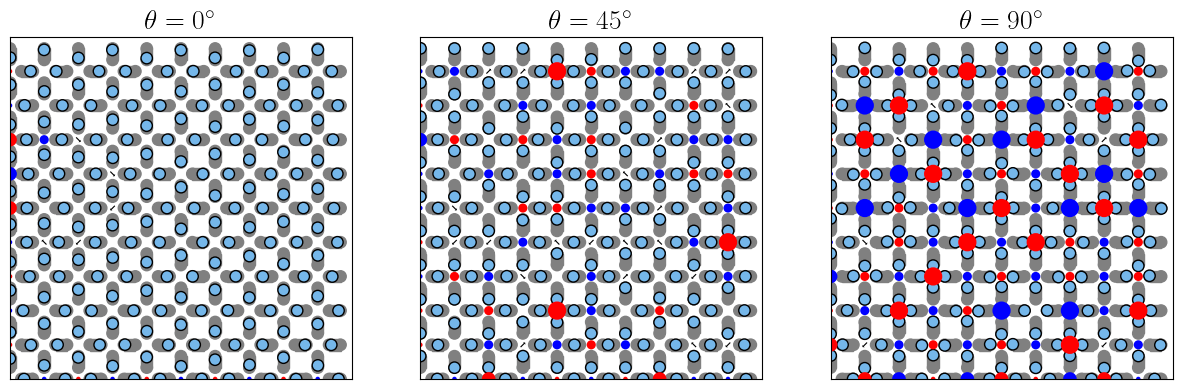

In [9]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

ax = axes[0]
key = '0'
ice.draw_frame(ctrjs[key],
               region=[0,300,0,300],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)
vrt[key].display(ax)
ax.set_title(f"$\\theta = {key} ^\\circ$", fontsize=20)

ax = axes[1]
key = '45'
ice.draw_frame(ctrjs[key],
               region=[0,300,0,300],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)
vrt[key].display(ax)
ax.set_title(f"$\\theta = {key} ^\\circ$", fontsize=20)

ax = axes[2]
key = '90'
ice.draw_frame(ctrjs[key],
               region=[0,300,0,300],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)
vrt[key].display(ax)
ax.set_title(f"$\\theta = {key} ^\\circ$", fontsize=20)

fig.savefig("../data/sys_figs.pdf",bbox_inches='tight')
fig.savefig("../data/sys_figs.jpeg",dpi=300,)
plt.show()

# Chirality

This section deals with chirality computations for all angles. \
Check the _chirality_tools.py_ for more information.

In [10]:
# General information

particle = ice.particle(radius = params["particle_radius"],
            susceptibility = params["particle_susceptibility"],
            diffusion = params["particle_diffusion"],
            temperature = params["particle_temperature"],
            density = params["particle_density"])

trap = ice.trap(trap_sep = params["trap_sep"],
            height = params["trap_height"],
            stiffness = params["trap_stiffness"])


params["particle"] = particle
params["trap"] = trap


In [11]:
angles_completed = np.sort([int(a) for a in os.listdir("../data/test11/angles")])
angles_completed

array([ 0, 30, 45, 60, 90])

In [ ]:
phi = []
runs = 10

for angle in tqdm(angles_completed):
    clear_output(wait=True)

    angle_chirs = [get_chirality_on_realization(params,angle,i) for i in range(1,runs+1)]

    phi.append(angle_chirs)

phi

In [12]:
phi_df = pd.DataFrame(phi)
phi_df.to_csv("../data/test11/chirality.csv")
phi_df

NameError: name 'phi' is not defined

# Complementary order parameter

$$
    Q = \sum_{i,j} (-1)^{i+j}q_{ij}
$$

In [31]:
for angle in tqdm(range(0,90+1)):
    for realization in range(1,10+1):
        angle_path = f"../data/test11/angles/{angle}/ctrj/ctrj{realization}.csv"

        try:
            os.mkdir(f"../data/test11/vertices/{angle}")
        except:
            pass

        vertex_path = f"../data/test11/vertices/{angle}/vertices{realization}.csv"
        try:
            vertices = get_vertices_last_frame(angle_path, last_frame=2399)
        except:
            vertices = get_vertices_last_frame(angle_path, last_frame=2399-1)


        vertices.to_csv(vertex_path)

    clear_output(wait=True)

100%|██████████| 58/58 [24:13<00:00, 25.07s/it]


In [108]:
psi= []
for angle in tqdm(range(90+1)):
    results = [get_charge_order_on_realization(params, angle,realization) for realization in range(1,10+1) ]
    psi.append(results)

100%|██████████| 91/91 [00:35<00:00,  2.58it/s]


In [111]:
psi_df = pd.DataFrame(psi)
psi_df.to_csv("../data/test11/charges.csv")

#  Importing data and ploting

In [3]:
#angles_completed = np.sort([int(a) for a in os.listdir("../data/test11/angles")])
angles_completed = list(range(0,90+1))
phi_df = pd.read_csv("../data/test11/chirality.csv",index_col=0).applymap(np.abs)
psi_df = pd.read_csv("../data/test11/charges.csv",index_col=0).applymap(np.abs)

In [4]:
phi_means = phi_df.mean(axis=1).to_list()
phi_sigmas = phi_df.var(axis=1).to_list()

psi_means = psi_df.mean(axis=1).to_list()
psi_sigmas = psi_df.var(axis=1).to_list()


In [5]:
plt.rcParams['axes.grid'] = True

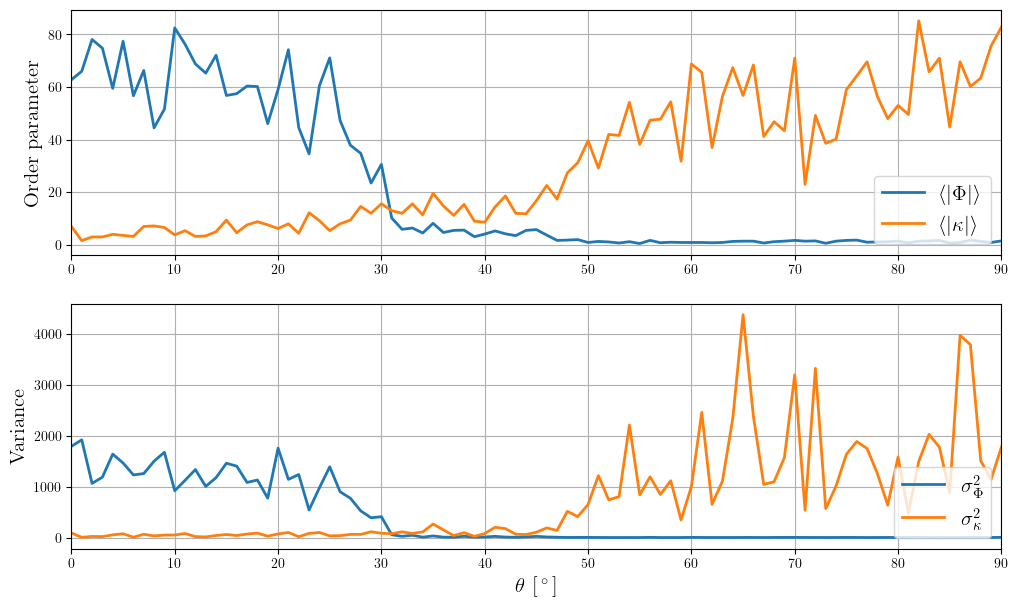

In [6]:
fig, axes = plt.subplots(2,1,figsize=(12,7))

ax = axes[0]
ax.plot(angles_completed,phi_means, label = "$\\langle |\\Phi|\\rangle$", lw=2.0)
ax.plot(angles_completed,psi_means, label = "$\\langle |\\kappa|\\rangle$", lw=2.0)
ax.set_ylabel("Order parameter", fontsize=15)
ax.set_xlim(0,90)
ax.legend(loc = 'lower right', fontsize=15)

ax = axes[1]

ax.plot(angles_completed,phi_sigmas, label="$\\sigma_\\Phi^2$", lw=2.0)
ax.plot(angles_completed,psi_sigmas, label="$\\sigma_\\kappa^2$", lw=2.0)

ax.set_xlabel("$\\theta \,\, [ \, ^\\circ \,]$",fontsize=15)
ax.set_ylabel("Variance", fontsize=15)

ax.legend(loc = 'lower right', fontsize=15)

ax.set_xlim(0,90)

plt.show()

fig.savefig("../data/order_param.pdf",bbox_inches='tight')
fig.savefig("../data/order_param.png",dpi=300)